In [1]:
# input: manual-periodogram
# output: ebai-estimates

import phoebe
from phoebe import u, c

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

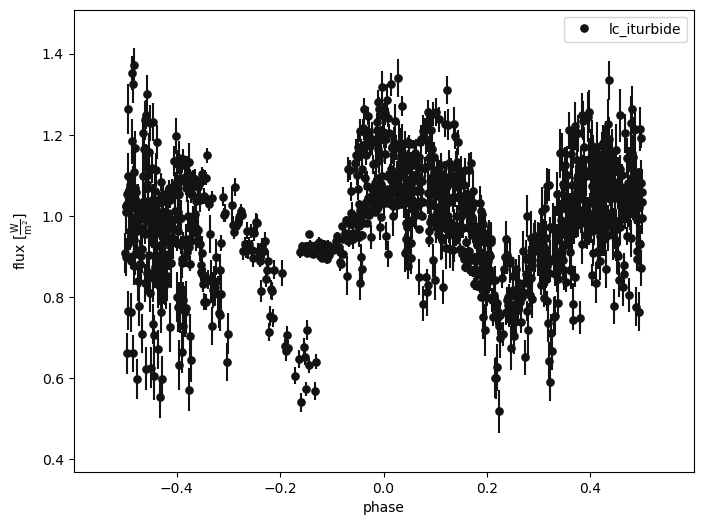

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [2]:
b = phoebe.load("./bundle-saves/manual-periodogram")
b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True, marker='.')

In [3]:
gaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' not in d]
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]
gaiaDatasets, rawGaiaDatasets

(['lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp'],
 ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw'])

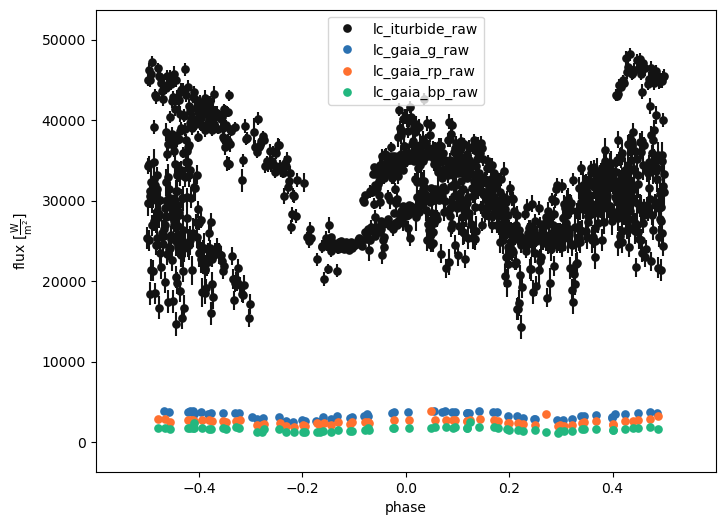

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [4]:
b.plot(x='phase', dataset=['lc_iturbide_raw'] + rawGaiaDatasets, show=True, legend=True, marker='.')

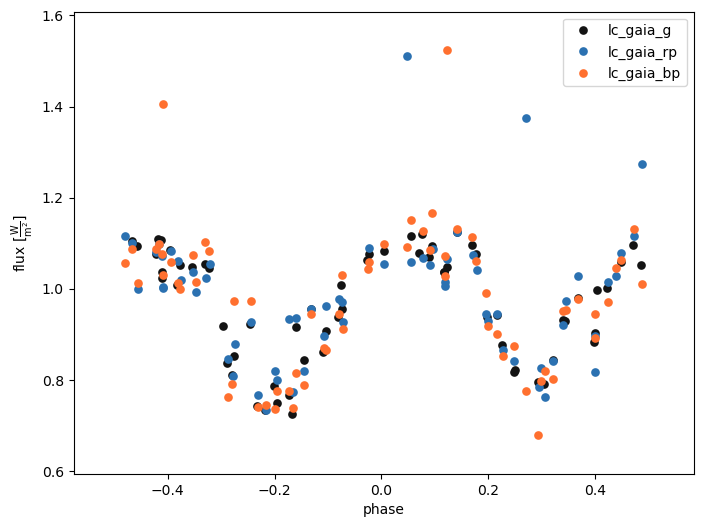

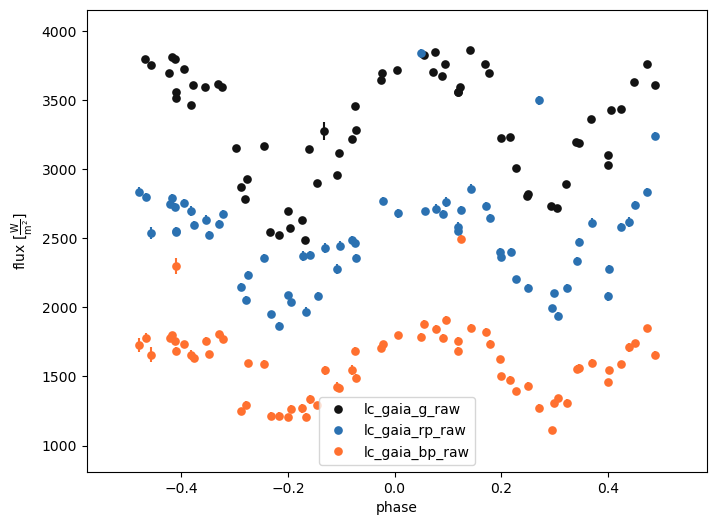

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [5]:
b.plot(x='phase', dataset=gaiaDatasets, show=True, legend=True, marker='.')
b.plot(x='phase', dataset=rawGaiaDatasets, show=True, legend=True, marker='.')

### Default forward models

In [6]:
# EBAI KNN values all seem to affect relative values
    # setting to dataset-scaled to see if at least general shape of model is correct
    # might also help with getting a good trend out of residuals when adopting estimator solutions
b.set_value_all(qualifier='pblum_mode', value='dataset-scaled')

# will probably use this strategy when optimizing; will try to optimize for pblum
# for d in b.datasets:
#     if "raw" in d:
#         b.set_value(qualifier='pblum_mode', dataset=d, value='absolute')
# print(b['pblum_mode'])

In [7]:
%%script echo "ignore distance set for now"
distance = 1000 / 0.38051966554433253 # GDR3 parallax, in mas (1000)

b.set_value(qualifier='distance', value=distance*u.pc)
print(distance, "pc")
print(b['distance'])

ignore distance set for now


In [8]:
print(b['pblum'])

ParameterSet: 0 parameters
NO PARAMETERS


100%|██████████| 1414/1414 [01:46<00:00, 13.28it/s]
Wed, 23 Aug 2023 16:27 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 16:27 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 16:27 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


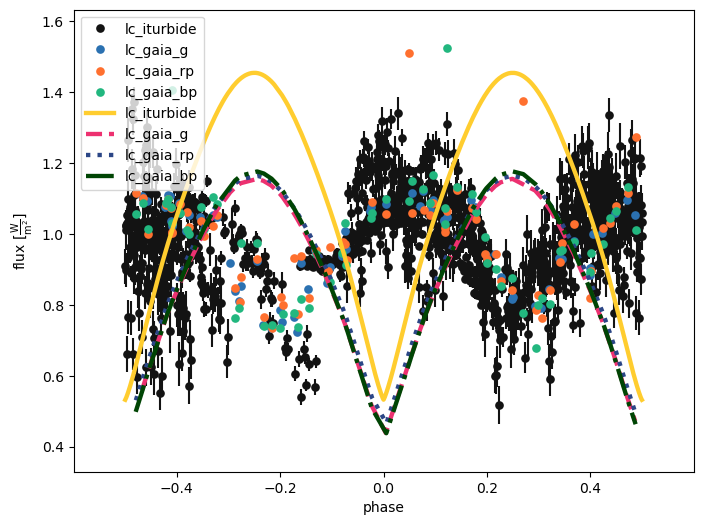

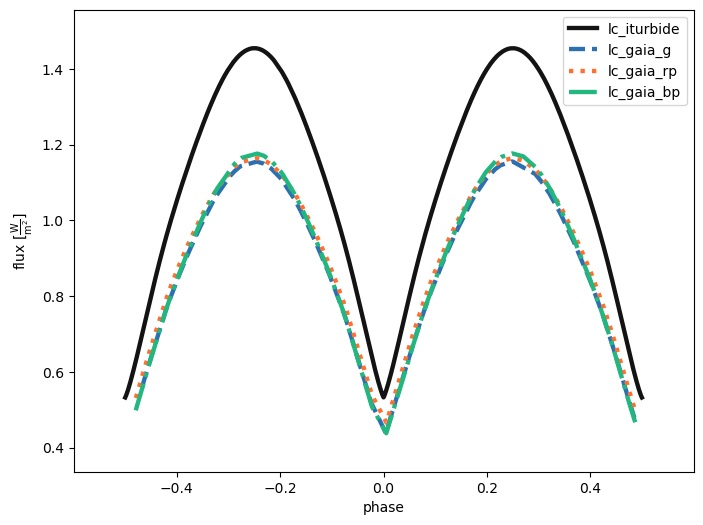

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [9]:
# run and show default forward model
# gen_utils.avoidAtmosphereErrors(b)
# b.run_compute(compute='fast_compute', model='fast_default')

gen_utils.abilitateDatasets(b, ['lc_iturbide'] + gaiaDatasets)

gen_utils.resetAtmosphere(b)
b.run_compute(compute='phoebe01', model='full_default', overwrite=True)

b.plot(x='phase', dataset=['lc_iturbide'] + gaiaDatasets, model='full_default', show=True, legend=True, marker={'dataset': '.'})
b.plot(['model'], x='phase', dataset=['lc_iturbide'] + gaiaDatasets, model='full_default', show=True, legend=True, marker={'dataset': '.'})

100%|██████████| 1414/1414 [01:44<00:00, 13.53it/s]


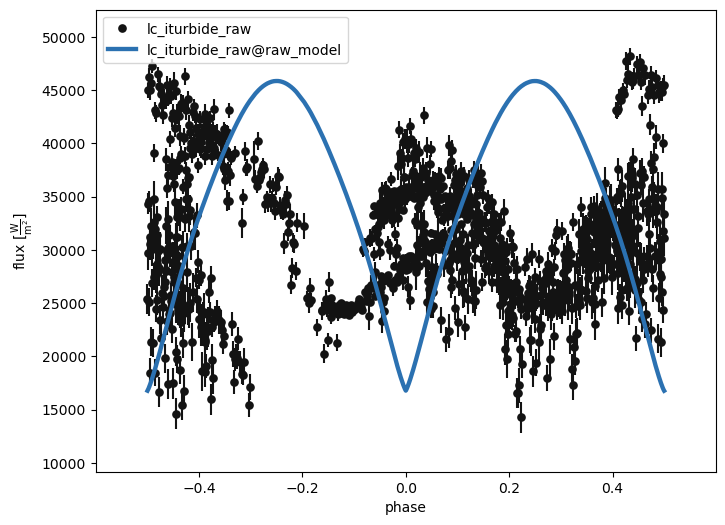

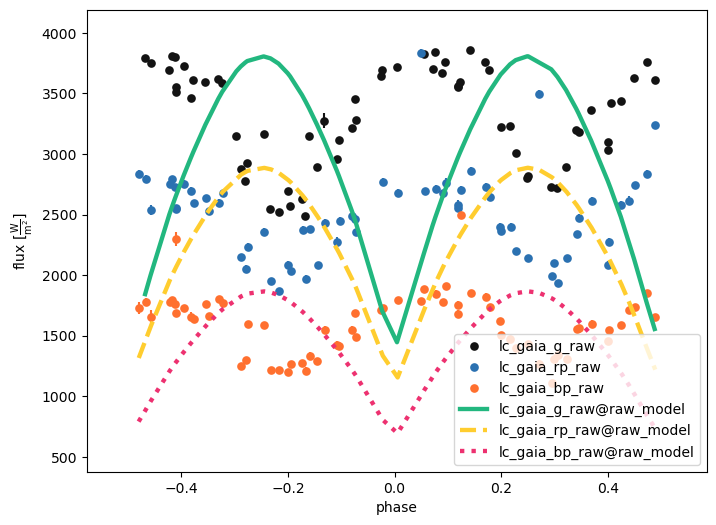

(<autofig.figure.Figure | 1 axes | 6 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [10]:
allRawDatasets = ['lc_iturbide_raw'] + rawGaiaDatasets
gen_utils.abilitateDatasets(b, allRawDatasets)

b.run_compute(compute='phoebe01', model='raw_model', overwrite=True)
b.plot(x='phase', dataset='lc_iturbide_raw', kind='lc', show=True, legend=True, marker={'dataset': '.'})
b.plot(x='phase', dataset=rawGaiaDatasets, kind='lc', show=True, legend=True, marker={'dataset': '.'})

## EBAI KNN estimator runs

In [11]:
# ignore sklearn warnings; caused by PHOEBE internals
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Normalized datasets

In [12]:
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn', lc_datasets=['lc_iturbide'] + gaiaDatasets, overwrite=True)
print(b['ebai_knn'])

b.run_solver(solver='ebai_knn', solution='ebai_knn_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_solution')
print()
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_solution', {'incl@binary@orbit@component': u.rad})

ParameterSet: 7 parameters
         comments@ebai_knn@solver: 
       use_server@ebai_knn@solver: none
      lc_datasets@ebai_knn@solver: ['lc_iturbide', 'lc_gaia_g', 'lc_gaia_rp', 'lc_gaia_bp']
       lc_combine@ebai_knn@solver: median
        phase_bin@ebai_knn@solver: False
      ebai_method@ebai_knn@solver: knn
            orbit@ebai_knn@solver: binary


Wed, 23 Aug 2023 16:29 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Wed, 23 Aug 2023 16:29 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


t0_supconj@binary@orbit@component = -0.05 d
teffratio@binary@orbit@component = 0.87 
incl@binary@orbit@component = 0.99 rad
fillout_factor@contact_envelope@envelope@component = 0.84 
q@binary@orbit@component = 2.55 

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 1.5707963267948966 rad
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [13]:
normalizedDatasets = ['lc_iturbide'] + gaiaDatasets
for d in normalizedDatasets:
	print(f"\nf'ebai_knn_{d}_solution'\n----------------------------------")
	b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver=f'ebai_knn_{d}', lc_datasets=[d], overwrite=True)
	b.run_solver(solver=f'ebai_knn_{d}', solution=f'ebai_knn_{d}_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_knn_{d}_solution')


f'ebai_knn_lc_iturbide_solution'
----------------------------------
t0_supconj@binary@orbit@component = -0.05 d
teffratio@binary@orbit@component = 0.96 
incl@binary@orbit@component = 1.15 rad
fillout_factor@contact_envelope@envelope@component = 0.72 
q@binary@orbit@component = 0.20 

f'ebai_knn_lc_gaia_g_solution'
----------------------------------
t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.91 
incl@binary@orbit@component = 1.43 rad
fillout_factor@contact_envelope@envelope@component = 0.42 
q@binary@orbit@component = 9.74 

f'ebai_knn_lc_gaia_rp_solution'
----------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0.81 
incl@binary@orbit@component = 0.99 rad
fillout_factor@contact_envelope@envelope@component = 0.78 
q@binary@orbit@component = 4.24 

f'ebai_knn_lc_gaia_bp_solution'
----------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0

In [14]:
# all normalized Gaia datasets
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_gaia', lc_datasets=gaiaDatasets, overwrite=True)
b.run_solver(solver='ebai_knn_gaia', solution='ebai_knn_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_gaia_solution')

t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.85 
incl@binary@orbit@component = 1.01 rad
fillout_factor@contact_envelope@envelope@component = 0.76 
q@binary@orbit@component = 2.15 


### Raw datasets

In [15]:
for d in allRawDatasets:
	print(f"\nf'ebai_knn_{d}_solution'\n----------------------------------")
	b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver=f'ebai_knn_{d}', lc_datasets=[d], overwrite=True)
	try:
		b.run_solver(solver=f'ebai_knn_{d}', solution=f'ebai_knn_{d}_solution', overwrite=True)
	except:
		print(f"Couldn't generate an estimator result using {d}")
		continue
	gen_utils.printFittedVals(b, f'ebai_knn_{d}_solution')


f'ebai_knn_lc_iturbide_raw_solution'
----------------------------------
2G model CG12 failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
2G model CG12E1 failed with error: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Couldn't generate an estimator result using lc_iturbide_raw

f'ebai_knn_lc_gaia_g_raw_solution'
----------------------------------
t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.93 
incl@binary@orbit@component = 1.47 rad
fillout_factor@contact_envelope@envelope@component = 0.46 
q@binary@orbit@component = 7.74 

f'ebai_knn_lc_gaia_rp_raw_solution'
----------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0.83 
incl@binary@orbit@component = 1.03 rad
fillout_factor@contact_envelope@envelope@component = 0.77 
q@binary@orbit@component = 3.71 

f'ebai_knn_lc_gaia_bp_raw_solution'
---------------

In [16]:
# all raw datasets
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_raw', lc_datasets=allRawDatasets, overwrite=True)
b.run_solver(solver='ebai_knn_raw', solution='ebai_knn_raw_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_raw_solution')

t0_supconj@binary@orbit@component = 0.07 d
teffratio@binary@orbit@component = 0.98 
incl@binary@orbit@component = 1.52 rad
fillout_factor@contact_envelope@envelope@component = 0.80 
q@binary@orbit@component = 9.44 


In [17]:
# raw Gaia datasets
b.add_solver('estimator.ebai', ebai_method='knn', phase_bin=False, solver='ebai_knn_raw_gaia', lc_datasets=rawGaiaDatasets, overwrite=True)
b.run_solver(solver='ebai_knn_raw_gaia', solution='ebai_knn_raw_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_knn_raw_gaia_solution')

t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.91 
incl@binary@orbit@component = 1.46 rad
fillout_factor@contact_envelope@envelope@component = 0.56 
q@binary@orbit@component = 9.42 


In [18]:
gen_utils.printFittedTwigsConstraints(b, 'ebai_knn_solution', {'incl@binary@orbit@component': u.rad})

  t0_supconj@binary@orbit@component 0.0 d
C teffratio@binary@orbit@component 1.0
  incl@binary@orbit@component 1.5707963267948966 rad
C fillout_factor@contact_envelope@envelope@component 0.6417897080770951
  q@binary@orbit@component 1.0


In [19]:
print(b['teffratio'])
print(b['fillout_factor'])
print(b['teff'])

ParameterSet: 2 parameters
C      teffratio@binary@component: 1.0
             teffratio@constraint: {teff@secondary@component} / {teff@primary@component}
ParameterSet: 2 parameters
C  fillout_factor@contact_enve...: 0.6417897080770951
        fillout_factor@constraint: pot_to_fillout_factor({q@binary@component}, {pot@contact_envelope@component})
ParameterSet: 2 parameters
           teff@primary@component: 6000.0 K
         teff@secondary@component: 6000.0 K


In [20]:
b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')

<ConstraintParameter: {pot@contact_envelope@component} = fillout_factor_to_pot({q@binary@component}, {fillout_factor@contact_envelope@component}) (solar units) => 3.4013774072298766>

## Testing fit of each solution

### Temporary back up
Storing the original bundle results in memory, in case need to revert arises

In [21]:
backupBundle = b.copy()

In [22]:
b = backupBundle.copy()

In [23]:
b.solutions, b.solvers

(['lcperiod_iturbide_auto_solution',
  'lcperiod_iturbide_manual_solution',
  'ebai_knn_solution',
  'ebai_knn_lc_iturbide_solution',
  'ebai_knn_lc_gaia_g_solution',
  'ebai_knn_lc_gaia_rp_solution',
  'ebai_knn_lc_gaia_bp_solution',
  'ebai_knn_gaia_solution',
  'ebai_knn_lc_gaia_g_raw_solution',
  'ebai_knn_lc_gaia_rp_raw_solution',
  'ebai_knn_lc_gaia_bp_raw_solution',
  'ebai_knn_raw_solution',
  'ebai_knn_raw_gaia_solution'],
 ['lcperiod_iturbide_auto',
  'lcperiod_iturbide_manual',
  'ebai_knn',
  'ebai_knn_lc_iturbide',
  'ebai_knn_lc_gaia_g',
  'ebai_knn_lc_gaia_rp',
  'ebai_knn_lc_gaia_bp',
  'ebai_knn_gaia',
  'ebai_knn_lc_iturbide_raw',
  'ebai_knn_lc_gaia_g_raw',
  'ebai_knn_lc_gaia_rp_raw',
  'ebai_knn_lc_gaia_bp_raw',
  'ebai_knn_raw',
  'ebai_knn_raw_gaia'])

### Checking solution goodness of fit

In [24]:
# gen_utils.abilitateDatasets(b, normalizedDatasets + allRawDatasets)
b.set_value_all(qualifier='enabled', value=True)
print(b['enabled'])

ParameterSet: 18 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@mesh01@fast_compute...: True
   enabled@lc_iturbide@phoebe0...: True
   enabled@lc_iturbide@fast_co...: True
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_raw@fas...: True
   enabled@lc_gaia_g@phoebe01@...: True
   enabled@lc_gaia_g@fast_comp...: True
   enabled@lc_gaia_rp@phoebe01...: True
   enabled@lc_gaia_rp@fast_com...: True
   enabled@lc_gaia_bp@phoebe01...: True
   enabled@lc_gaia_bp@fast_com...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_g_raw@fast_...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_rp_raw@fast...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@fast...: True


In [25]:
print(b['requiv'])
print(b['sma@binary'])

ParameterSet: 4 parameters
C        requiv@primary@component: 1.5 solRad
C      requiv@secondary@component: 1.4999999999999996 solRad
        requiv@primary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 1)
      requiv@secondary@constraint: pot_to_requiv_contact({pot@contact_envelope@component}, {q@binary@component}, {sma@binary@component}, 2)
Parameter: sma@binary@component
                       Qualifier: sma
                     Description: Semi-major axis of the orbit (defined at time t0@system)
                           Value: 3.35 solRad
                  Constrained by: 
                      Constrains: asini@binary@component, requiv@secondary@component, requivratio@binary@component, requivsumfrac@binary@component, mass@primary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@seconda

ebai_knn_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.05 d
teffratio@binary@orbit@component = 0.87 
incl@binary@orbit@component = 0.99 rad
fillout_factor@contact_envelope@envelope@component = 0.84 
q@binary@orbit@component = 2.55 


100%|██████████| 1414/1414 [02:15<00:00, 10.42it/s]
Wed, 23 Aug 2023 22:39 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 22:39 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 22:39 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide -11.65707384088181 W / m2
	 lc_iturbide_raw -467277.1242114408 W / m2
	 lc_gaia_g 0.19779678360510744 W / m2
	 lc_gaia_rp 0.20182713538118013 W / m2
	 lc_gaia_bp 0.09334364264989048 W / m2
	 lc_gaia_g_raw 1646.265737473021 W / m2
	 lc_gaia_rp_raw 1594.4816698918862 W / m2
	 lc_gaia_bp_raw 873.1821767598949 W / m2


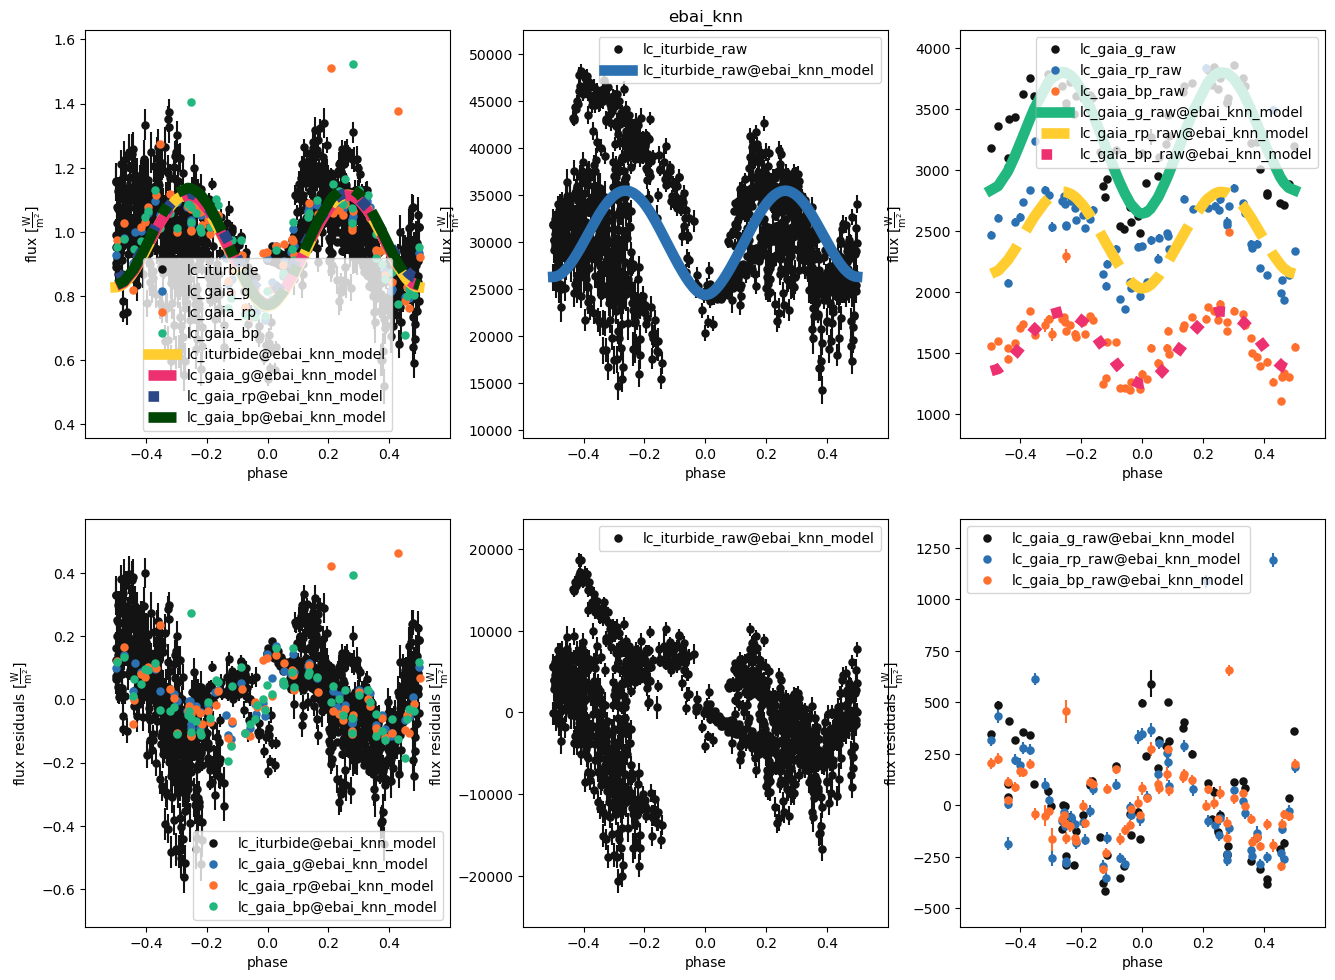

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_iturbide_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.05 d
teffratio@binary@orbit@component = 0.96 
incl@binary@orbit@component = 1.15 rad
fillout_factor@contact_envelope@envelope@component = 0.72 
q@binary@orbit@component = 0.20 


100%|██████████| 1414/1414 [01:59<00:00, 11.83it/s]
Wed, 23 Aug 2023 22:44 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 22:44 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 22:44 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide -0.6252947461265443 W / m2
	 lc_iturbide_raw 40581.320031646406 W / m2
	 lc_gaia_g 0.08476841785408173 W / m2
	 lc_gaia_rp 0.13930377832373741 W / m2
	 lc_gaia_bp -0.0499496790833327 W / m2
	 lc_gaia_g_raw 1748.2837463132414 W / m2
	 lc_gaia_rp_raw 1545.158634895286 W / m2
	 lc_gaia_bp_raw 823.5038597127182 W / m2


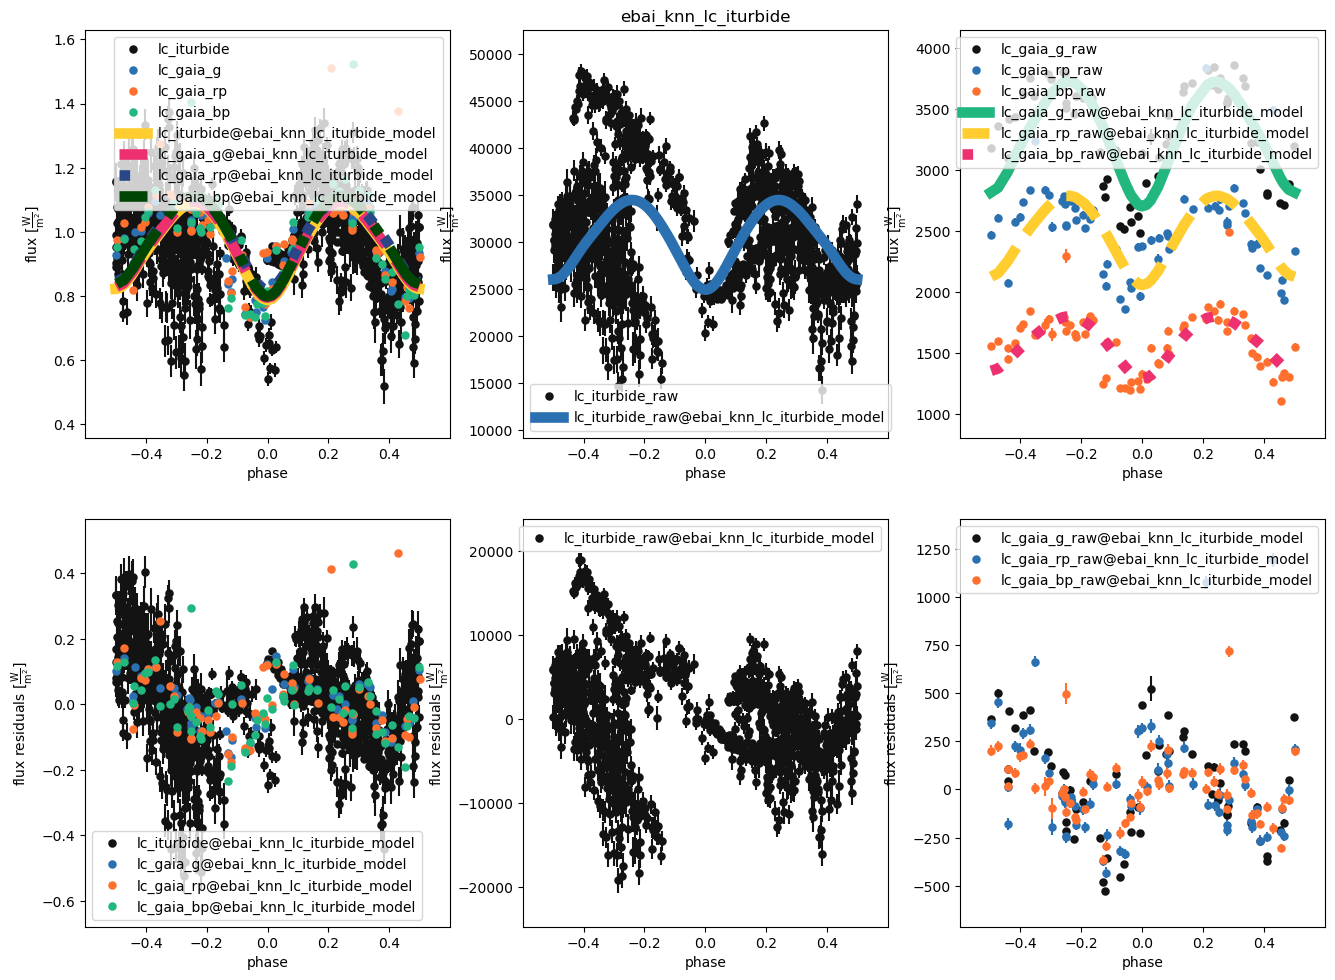

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_gaia_g_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.91 
incl@binary@orbit@component = 1.43 rad
fillout_factor@contact_envelope@envelope@component = 0.42 
q@binary@orbit@component = 9.74 


100%|██████████| 1414/1414 [01:41<00:00, 13.89it/s]
Wed, 23 Aug 2023 22:48 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 22:48 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 22:48 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide -3.9153616155467996 W / m2
	 lc_iturbide_raw -113810.47860069829 W / m2
	 lc_gaia_g 0.10250969634635543 W / m2
	 lc_gaia_rp 0.12901446689630214 W / m2
	 lc_gaia_bp 0.007555458605798093 W / m2
	 lc_gaia_g_raw 1457.7724696754426 W / m2
	 lc_gaia_rp_raw 1377.4262424213107 W / m2
	 lc_gaia_bp_raw 752.4798967321703 W / m2


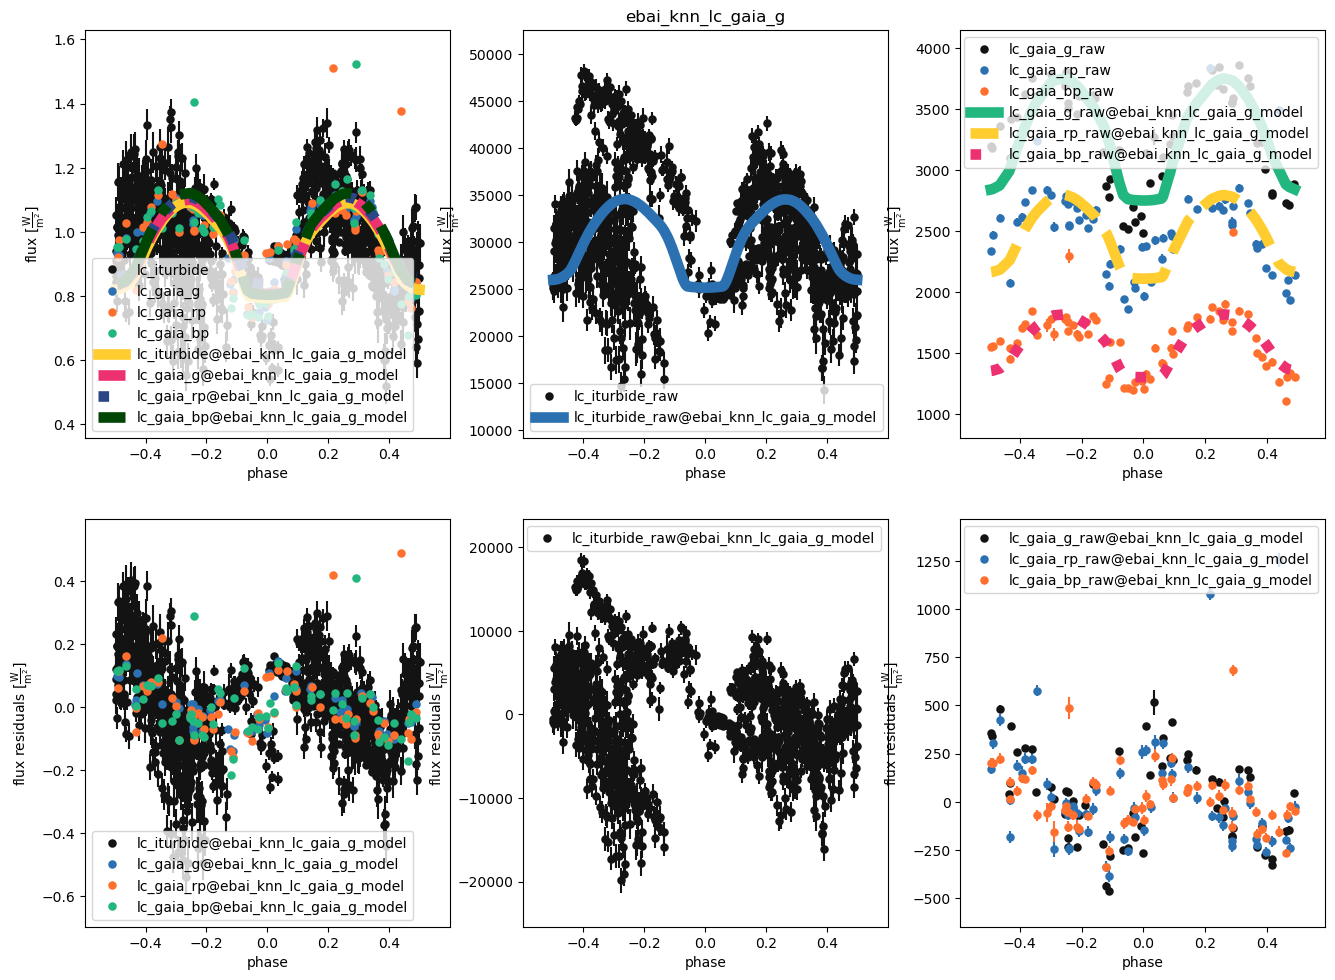

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_gaia_rp_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0.81 
incl@binary@orbit@component = 0.99 rad
fillout_factor@contact_envelope@envelope@component = 0.78 
q@binary@orbit@component = 4.24 


100%|██████████| 1414/1414 [02:02<00:00, 11.56it/s]
Wed, 23 Aug 2023 22:52 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 22:52 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 22:52 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide 4.1680375040859765 W / m2
	 lc_iturbide_raw 427827.7305613826 W / m2
	 lc_gaia_g -0.01144898596648447 W / m2
	 lc_gaia_rp -0.01261084267287238 W / m2
	 lc_gaia_bp -0.042105997935591444 W / m2
	 lc_gaia_g_raw 1766.128101916608 W / m2
	 lc_gaia_rp_raw 764.0845514599666 W / m2
	 lc_gaia_bp_raw 450.10144433258324 W / m2


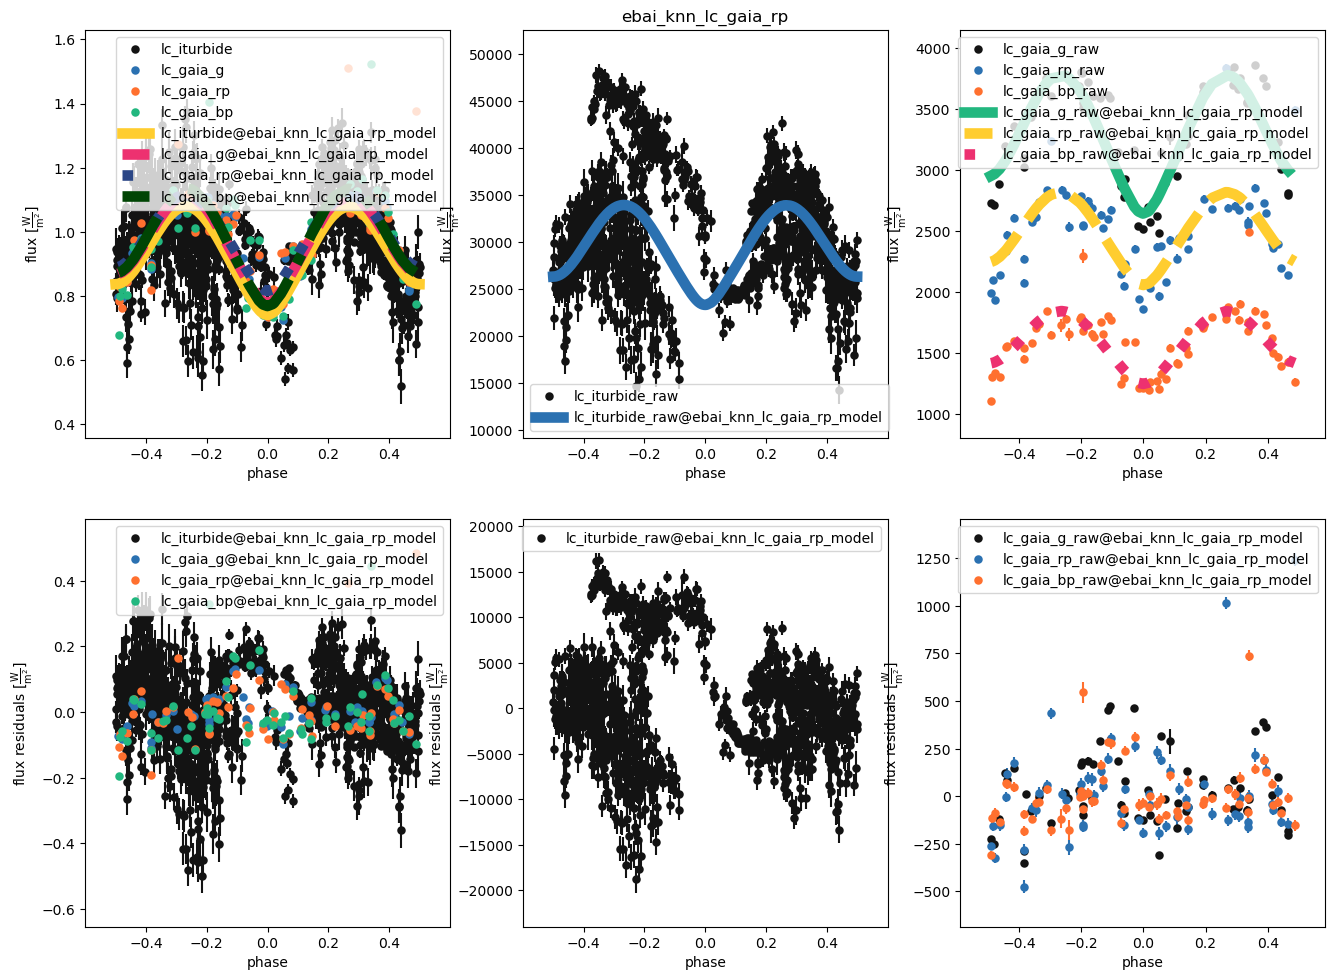

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_gaia_bp_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0.93 
incl@binary@orbit@component = 1.22 rad
fillout_factor@contact_envelope@envelope@component = 0.75 
q@binary@orbit@component = 1.12 


100%|██████████| 1414/1414 [02:07<00:00, 11.10it/s]
Wed, 23 Aug 2023 22:56 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 22:56 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 22:56 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide 31.633900314165743 W / m2
	 lc_iturbide_raw 1103558.6654642723 W / m2
	 lc_gaia_g 0.8053374795119124 W / m2
	 lc_gaia_rp 0.8474408061956182 W / m2
	 lc_gaia_bp 0.8048961527818947 W / m2
	 lc_gaia_g_raw 1243.111638342371 W / m2
	 lc_gaia_rp_raw 2163.946706180379 W / m2
	 lc_gaia_bp_raw 1171.4528738249276 W / m2


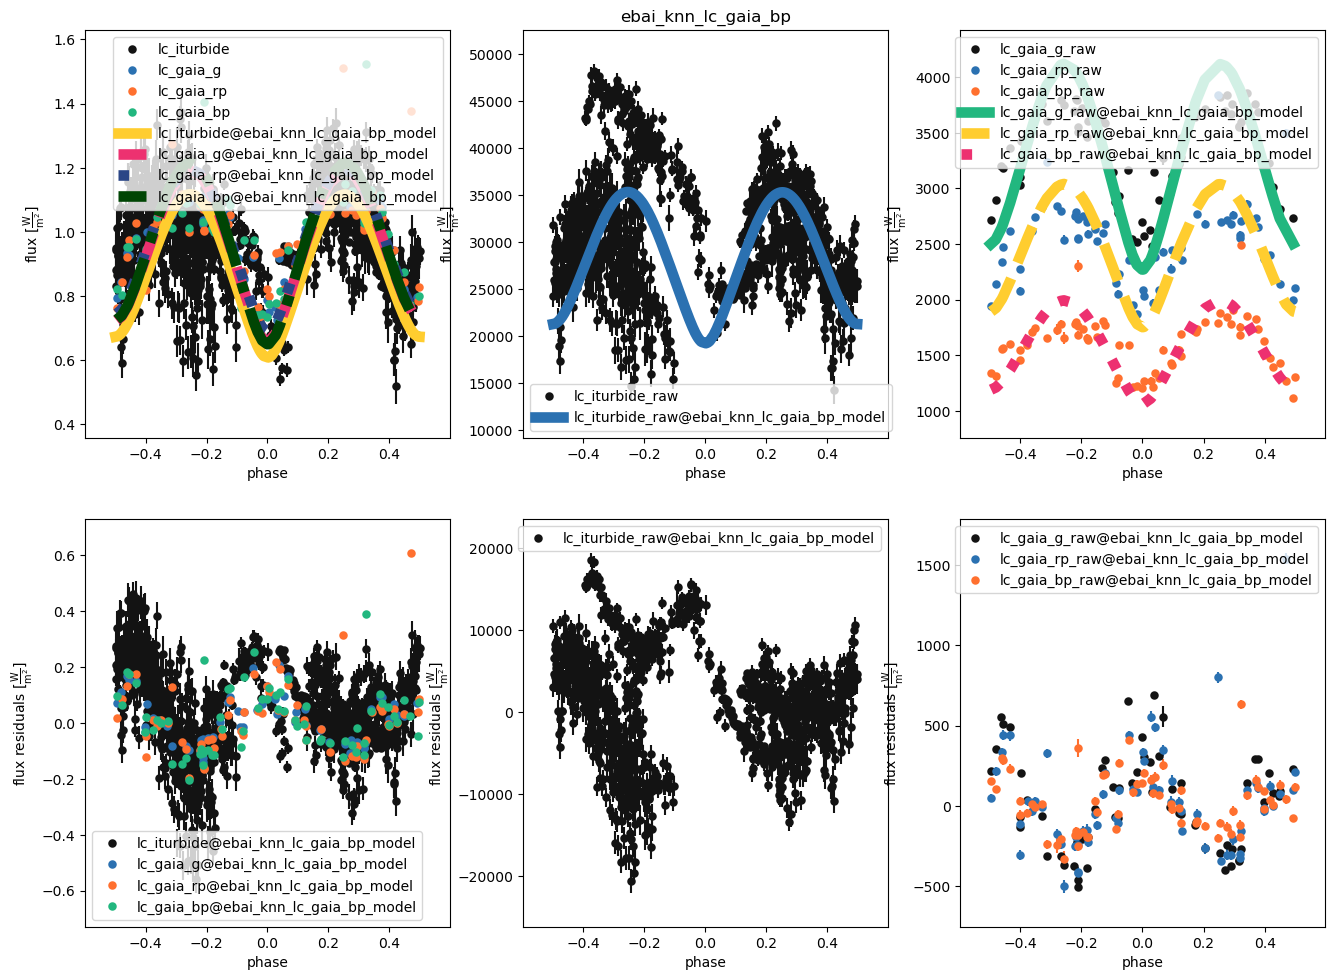

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_gaia_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.85 
incl@binary@orbit@component = 1.01 rad
fillout_factor@contact_envelope@envelope@component = 0.76 
q@binary@orbit@component = 2.15 


100%|██████████| 1414/1414 [02:12<00:00, 10.66it/s]
Wed, 23 Aug 2023 23:01 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 23:01 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 23:01 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide -8.486401085445195 W / m2
	 lc_iturbide_raw -352304.6464003064 W / m2
	 lc_gaia_g 0.2242683070270587 W / m2
	 lc_gaia_rp 0.23019989076340863 W / m2
	 lc_gaia_bp 0.1259343722712063 W / m2
	 lc_gaia_g_raw 1491.763820349755 W / m2
	 lc_gaia_rp_raw 1526.7725336577328 W / m2
	 lc_gaia_bp_raw 825.444061721015 W / m2


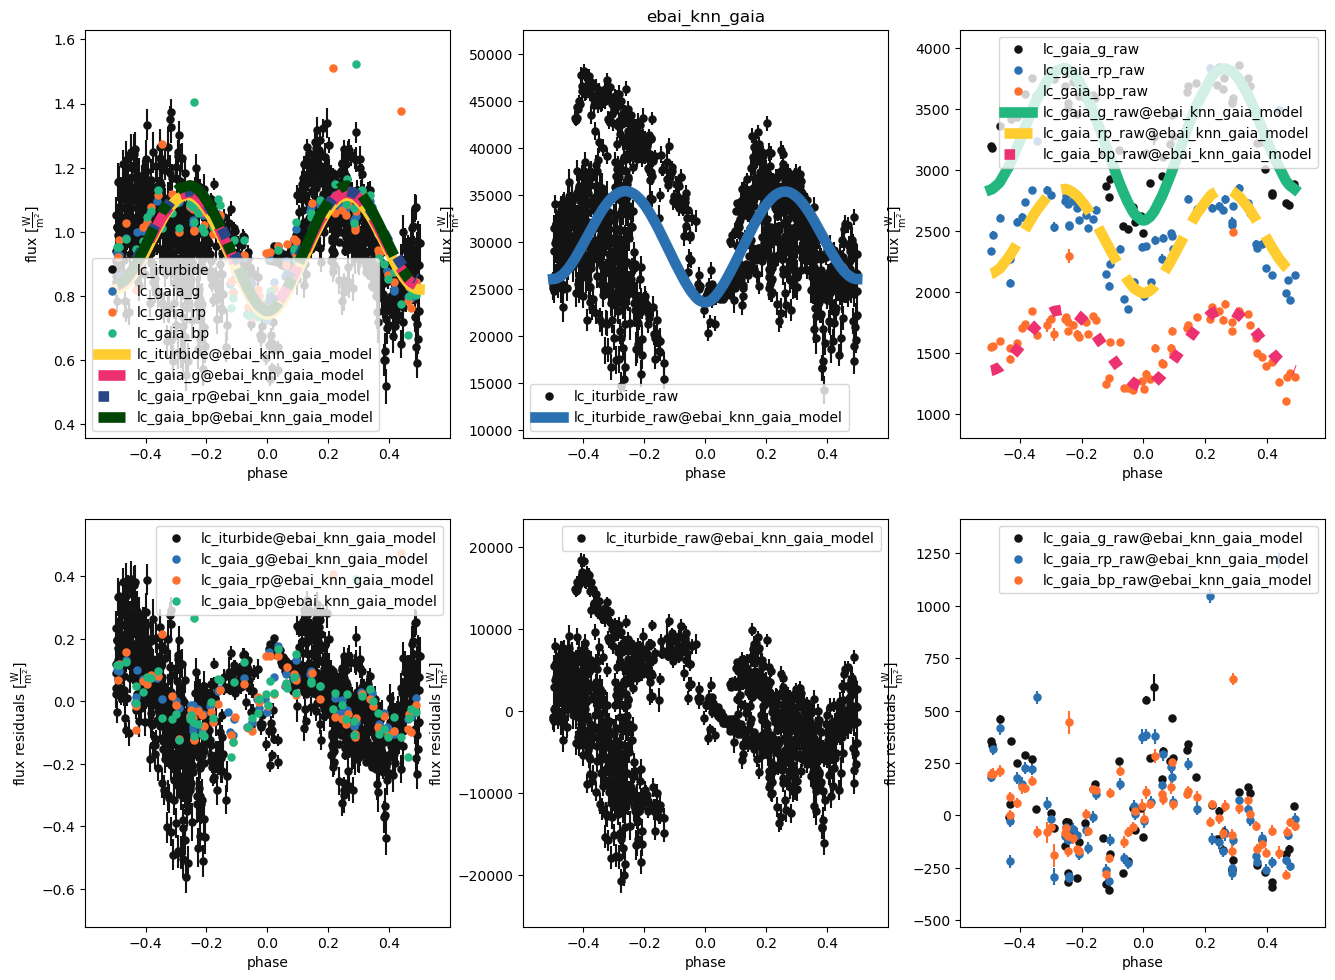

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_gaia_g_raw_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.93 
incl@binary@orbit@component = 1.47 rad
fillout_factor@contact_envelope@envelope@component = 0.46 
q@binary@orbit@component = 7.74 


100%|██████████| 1414/1414 [01:49<00:00, 12.92it/s]
Wed, 23 Aug 2023 23:05 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 23:05 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 23:05 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide 1.5582813747356634 W / m2
	 lc_iturbide_raw 30952.60362863331 W / m2
	 lc_gaia_g 0.21995367651461406 W / m2
	 lc_gaia_rp 0.2510778982667283 W / m2
	 lc_gaia_bp 0.12104695349364958 W / m2
	 lc_gaia_g_raw 1359.9957217645474 W / m2
	 lc_gaia_rp_raw 1566.2170420417256 W / m2
	 lc_gaia_bp_raw 824.5777843857927 W / m2


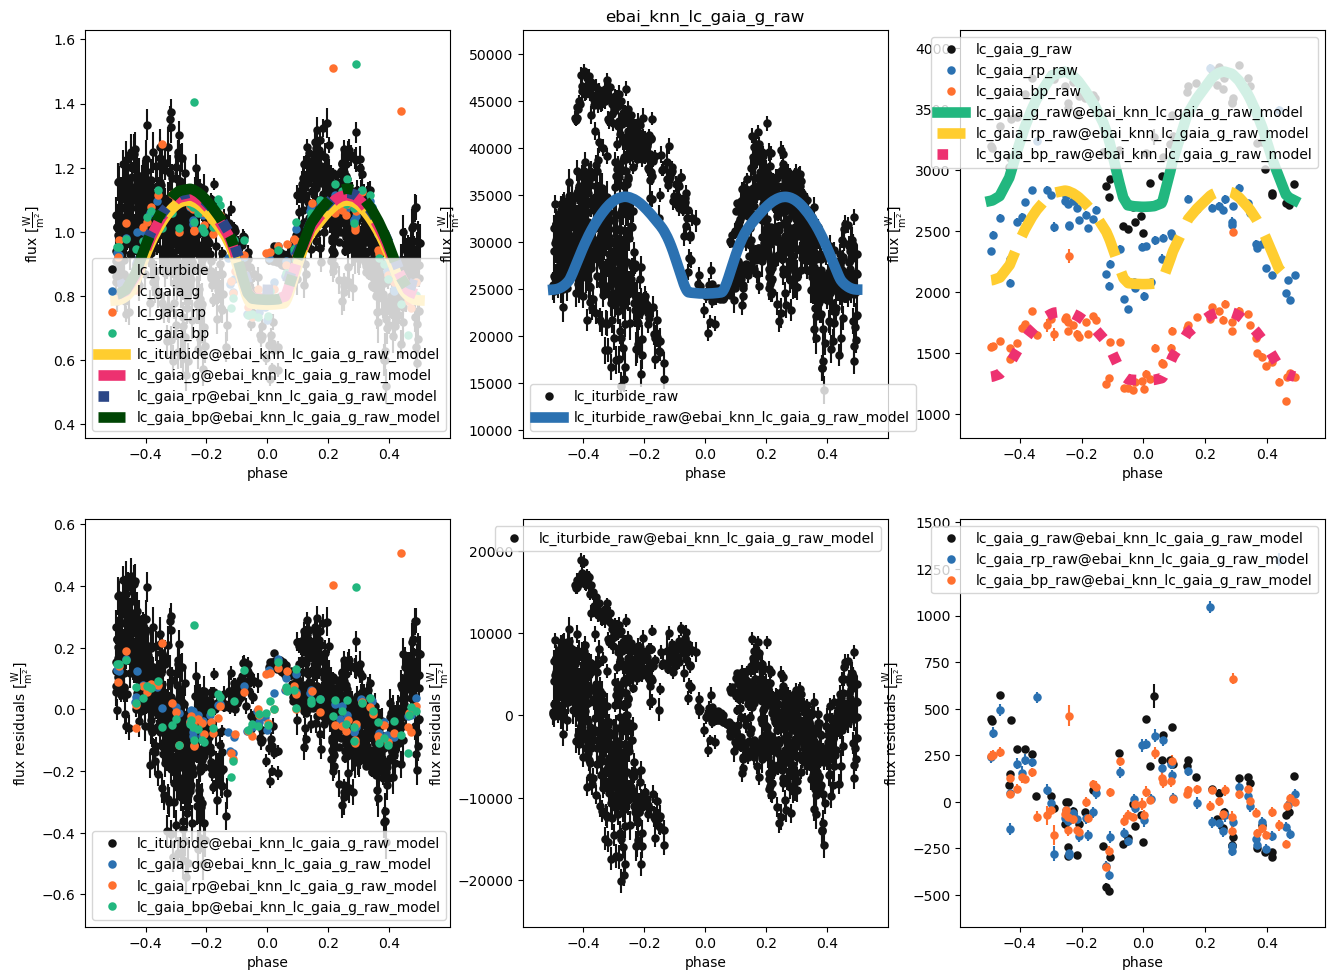

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_gaia_rp_raw_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0.83 
incl@binary@orbit@component = 1.03 rad
fillout_factor@contact_envelope@envelope@component = 0.77 
q@binary@orbit@component = 3.71 


100%|██████████| 1414/1414 [02:05<00:00, 11.27it/s]
Wed, 23 Aug 2023 23:09 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 23:09 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 23:09 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide 8.387960154951541 W / m2
	 lc_iturbide_raw 561605.0789270196 W / m2
	 lc_gaia_g 0.039170303998722344 W / m2
	 lc_gaia_rp 0.042480168436114574 W / m2
	 lc_gaia_bp 0.012562117075897827 W / m2
	 lc_gaia_g_raw 1575.4958568284678 W / m2
	 lc_gaia_rp_raw 785.4685863383727 W / m2
	 lc_gaia_bp_raw 441.38582357264613 W / m2


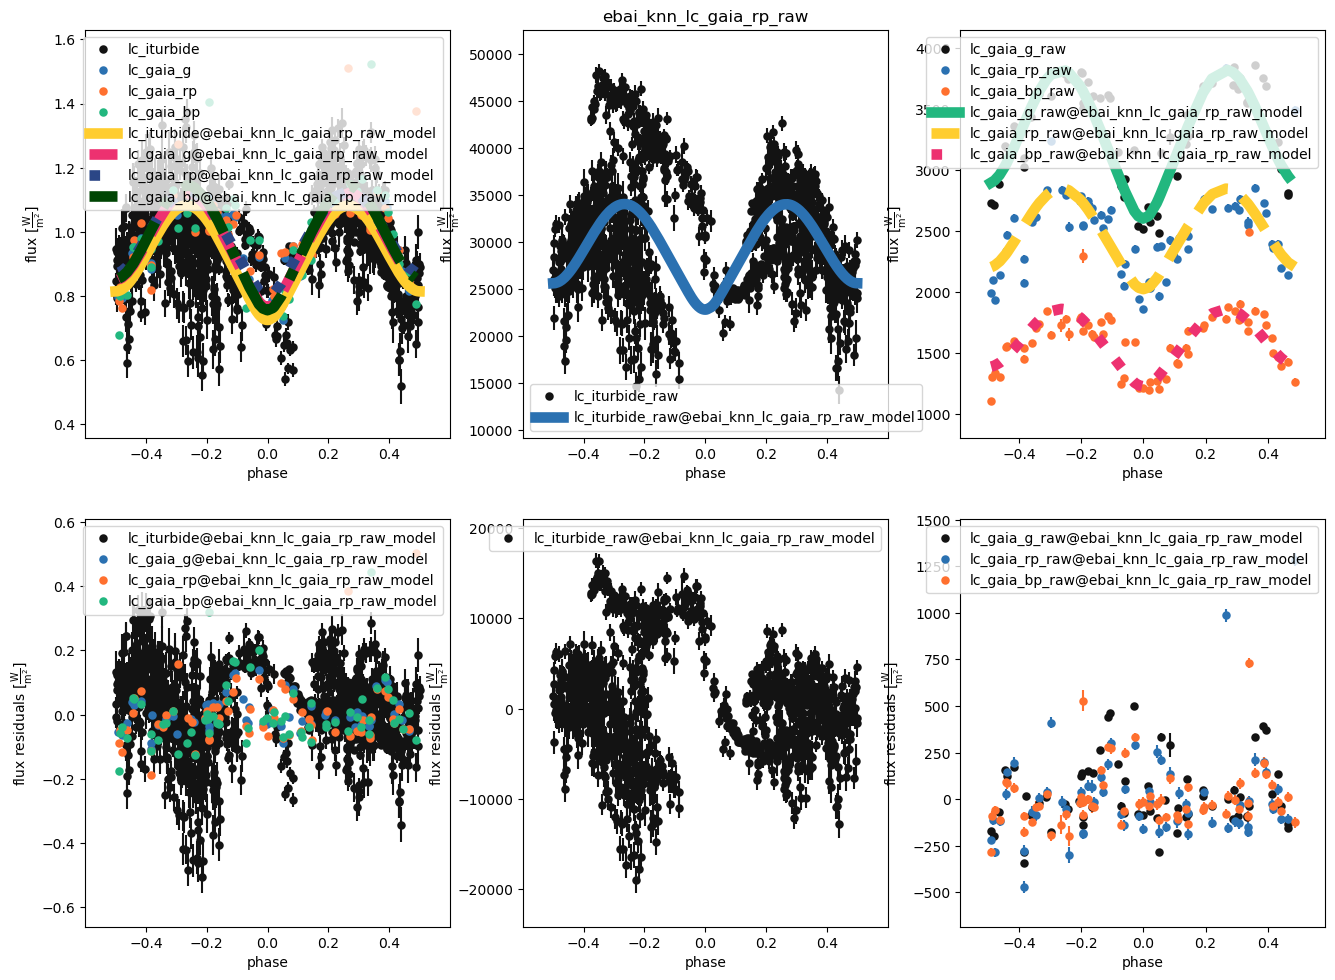

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_lc_gaia_bp_raw_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.07 d
teffratio@binary@orbit@component = 0.91 
incl@binary@orbit@component = 1.08 rad
fillout_factor@contact_envelope@envelope@component = 0.85 
q@binary@orbit@component = 1.26 


100%|██████████| 1414/1414 [02:07<00:00, 11.06it/s]
Wed, 23 Aug 2023 23:14 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 23:14 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 23:14 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide 20.94025431946929 W / m2
	 lc_iturbide_raw 800818.4645621935 W / m2
	 lc_gaia_g 0.37588670867449936 W / m2
	 lc_gaia_rp 0.4002460559333719 W / m2
	 lc_gaia_bp 0.3364882236225961 W / m2
	 lc_gaia_g_raw 754.168498335177 W / m2
	 lc_gaia_rp_raw 1366.3723152085063 W / m2
	 lc_gaia_bp_raw 657.5806582150808 W / m2


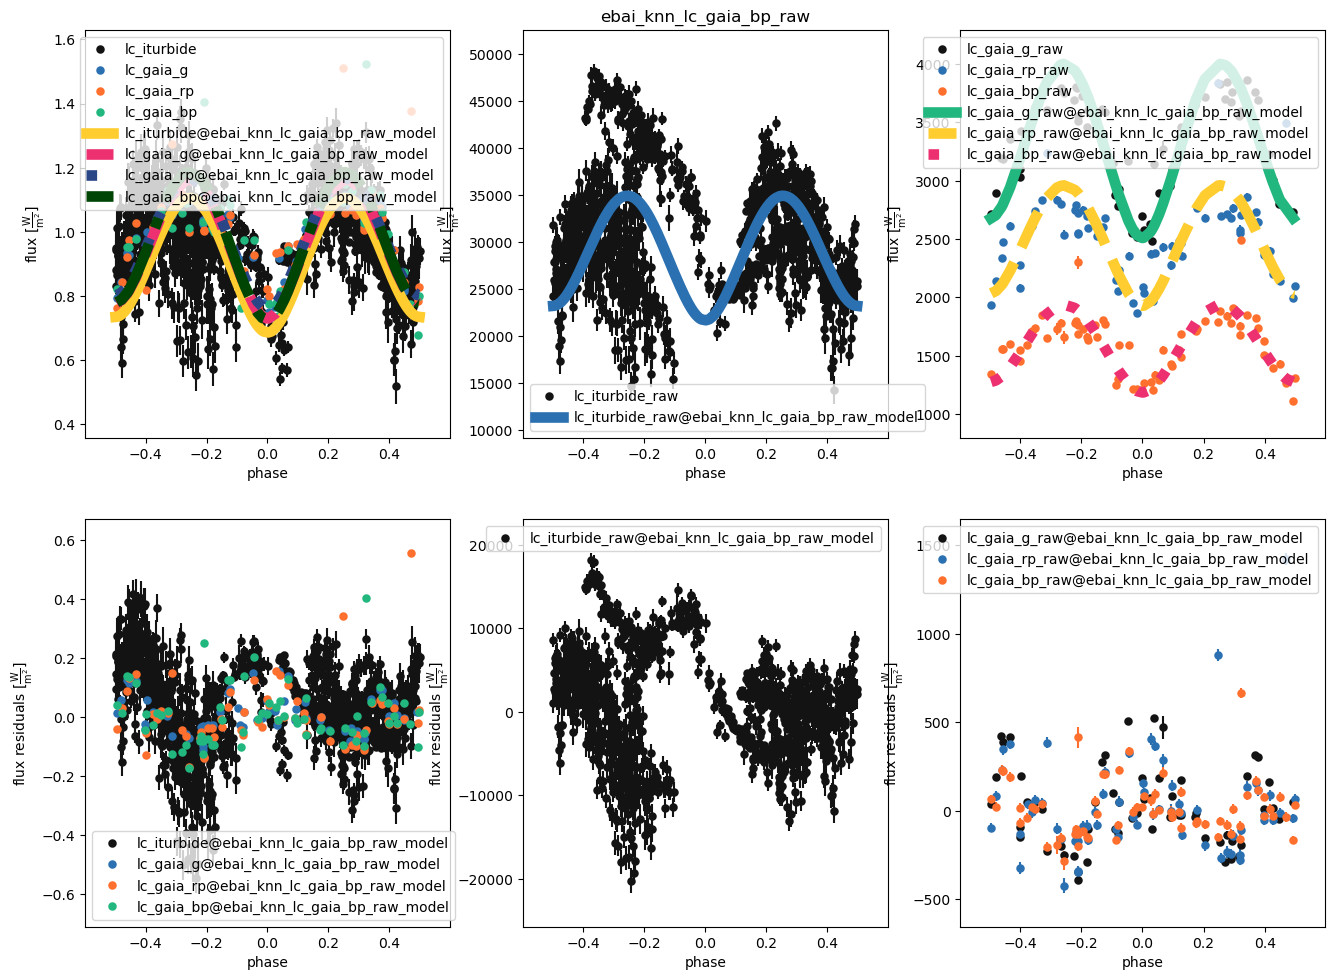

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_solution
-------------------------------
t0_supconj@binary@orbit@component = 0.07 d
teffratio@binary@orbit@component = 0.98 
incl@binary@orbit@component = 1.52 rad
fillout_factor@contact_envelope@envelope@component = 0.80 
q@binary@orbit@component = 9.44 


100%|██████████| 1414/1414 [01:39<00:00, 14.28it/s]
Wed, 23 Aug 2023 23:18 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 23:18 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 23:18 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide 24.602752129543898 W / m2
	 lc_iturbide_raw 1559920.540875977 W / m2
	 lc_gaia_g 0.30872360401917553 W / m2
	 lc_gaia_rp 0.281116357835988 W / m2
	 lc_gaia_bp 0.41497480417216803 W / m2
	 lc_gaia_g_raw 4198.088586945171 W / m2
	 lc_gaia_rp_raw 1571.769949818576 W / m2
	 lc_gaia_bp_raw 1081.438641951095 W / m2


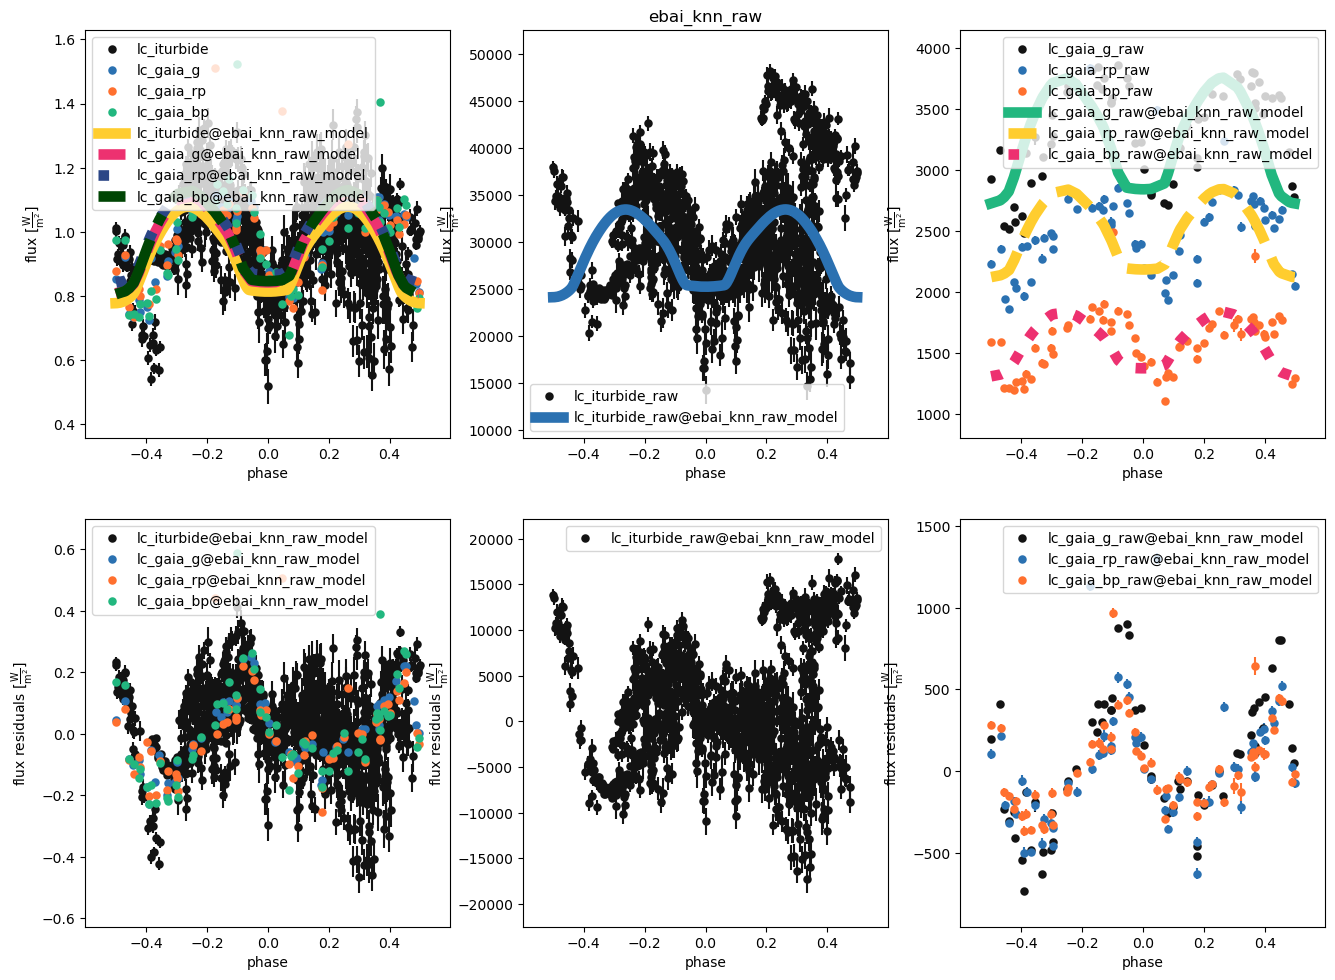

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

ebai_knn_raw_gaia_solution
-------------------------------
t0_supconj@binary@orbit@component = -0.06 d
teffratio@binary@orbit@component = 0.91 
incl@binary@orbit@component = 1.46 rad
fillout_factor@contact_envelope@envelope@component = 0.56 
q@binary@orbit@component = 9.42 


100%|██████████| 1414/1414 [01:45<00:00, 13.40it/s]
Wed, 23 Aug 2023 23:22 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009667118746194401 for dataset='lc_gaia_g'
Wed, 23 Aug 2023 23:22 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009848743338464008 for dataset='lc_gaia_rp'
Wed, 23 Aug 2023 23:22 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0009776638789814802 for dataset='lc_gaia_bp'


Total residuals
	 lc_iturbide -1.8907287570376585 W / m2
	 lc_iturbide_raw -79965.3627922649 W / m2
	 lc_gaia_g 0.16953292739931014 W / m2
	 lc_gaia_rp 0.18810313330504236 W / m2
	 lc_gaia_bp 0.0797091415038188 W / m2
	 lc_gaia_g_raw 1329.4566140506154 W / m2
	 lc_gaia_rp_raw 1458.5386212266699 W / m2
	 lc_gaia_bp_raw 800.4209411880986 W / m2


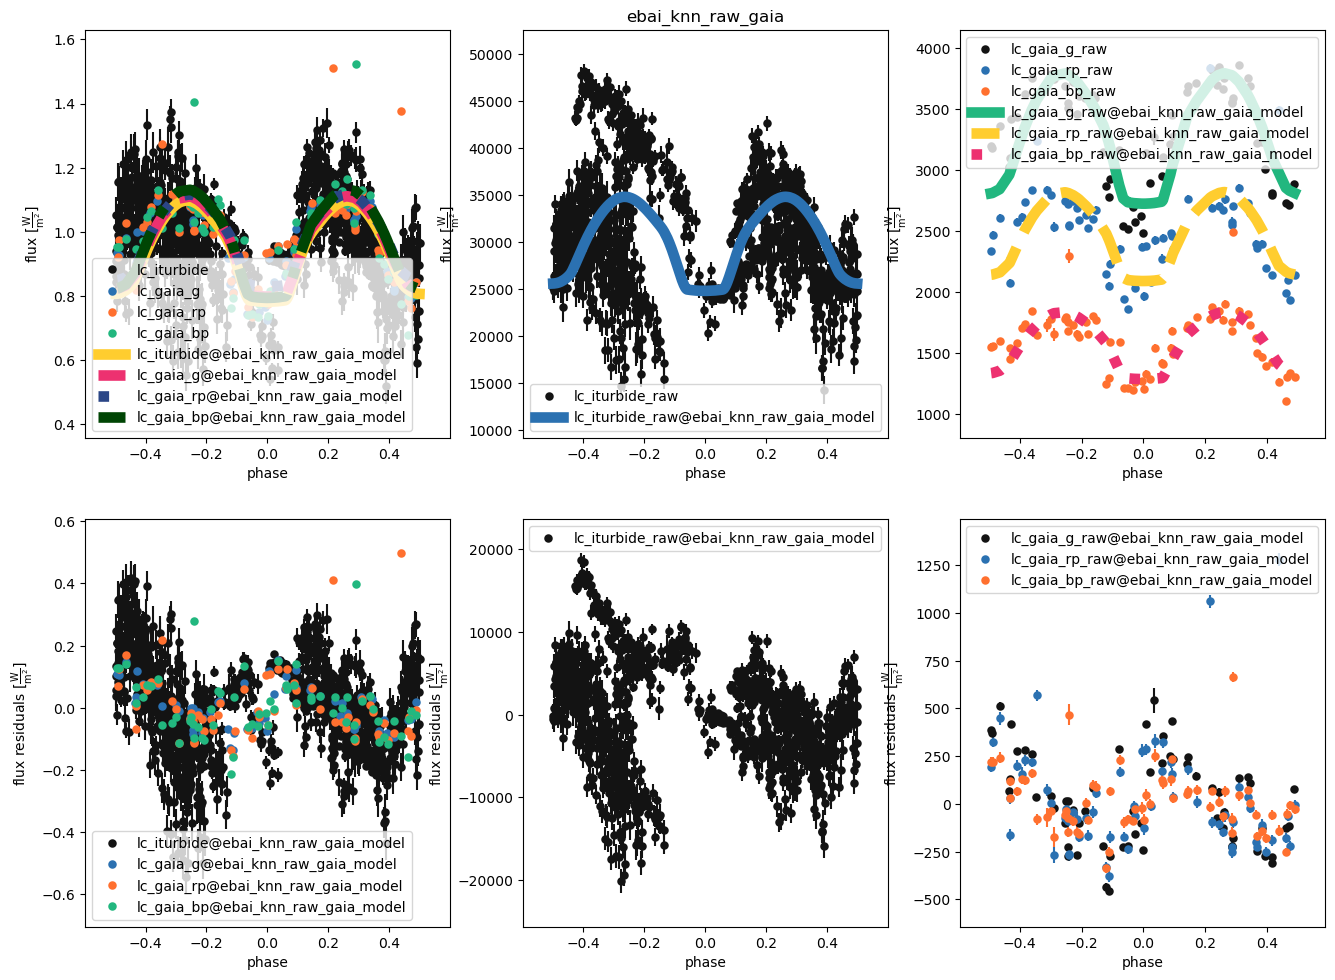

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

GridspecLayout(children=(HTML(value='<video width="800" height="600" controls autoplay loop>\n  <source type="…

In [29]:
# take all of the estimator solutions one by one and check for best fit
	# maybe use chi2 measure?
	# definitely plot residuals
for solver in [s for s in b.solvers if 'ebai_knn' in s]:
	solution = f"{solver}_solution"
	model = f"{solver}_model"

	# skipping any failed solvers
	if solution not in b.solutions:
		continue
	print(solution)
	print("-------------------------------")
	gen_utils.printFittedVals(b, solution)

	b.adopt_solution(solution=solution)
	b.run_compute(model=model, compute='phoebe01', overwrite=True)

	print("Total residuals")
	for d in b.datasets:
		if d == 'mesh01':
			continue
		print("\t", d, np.sum(b.calculate_residuals(model=model, dataset=d)))

	b.plot(x='phase', model=model, dataset=normalizedDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=1)
	b.plot(x='phase', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, title=solver, axorder=2)
	b.plot(x='phase', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, marker={'dataset': '.'}, s={'dataset': 0.008}, axorder=3)

	b.plot(x='phase', y='residuals', model=model, dataset=normalizedDatasets, kind='lc', legend=True, marker='.', s=0.008, axorder=4)
	b.plot(x='phase', y='residuals', model=model, dataset=['lc_iturbide_raw'], kind='lc', legend=True, marker='.', s=0.008, axorder=5)
	b.plot(x='phase', y='residuals', model=model, dataset=rawGaiaDatasets, kind='lc', legend=True, show=True, marker='.', s=0.008, draw_title=True, axorder=6, subplot_grid=(3,3), save=f"./graphs/ebai/{solver}")

	gen_utils.displayAnims(1, 3, 
			gen_utils.genAnimatedMesh(b, logger, model=model, draw_title=True, title=model, save=f"./graphs/anims/{solver}.gif"),
			gen_utils.genAnimatedMesh(b, logger, model=model, component='primary', draw_title=True, title=f"{model} - Primary"),
			gen_utils.genAnimatedMesh(b, logger, model=model, component='secondary', draw_title=True, title=f"{model} - Secondary"))

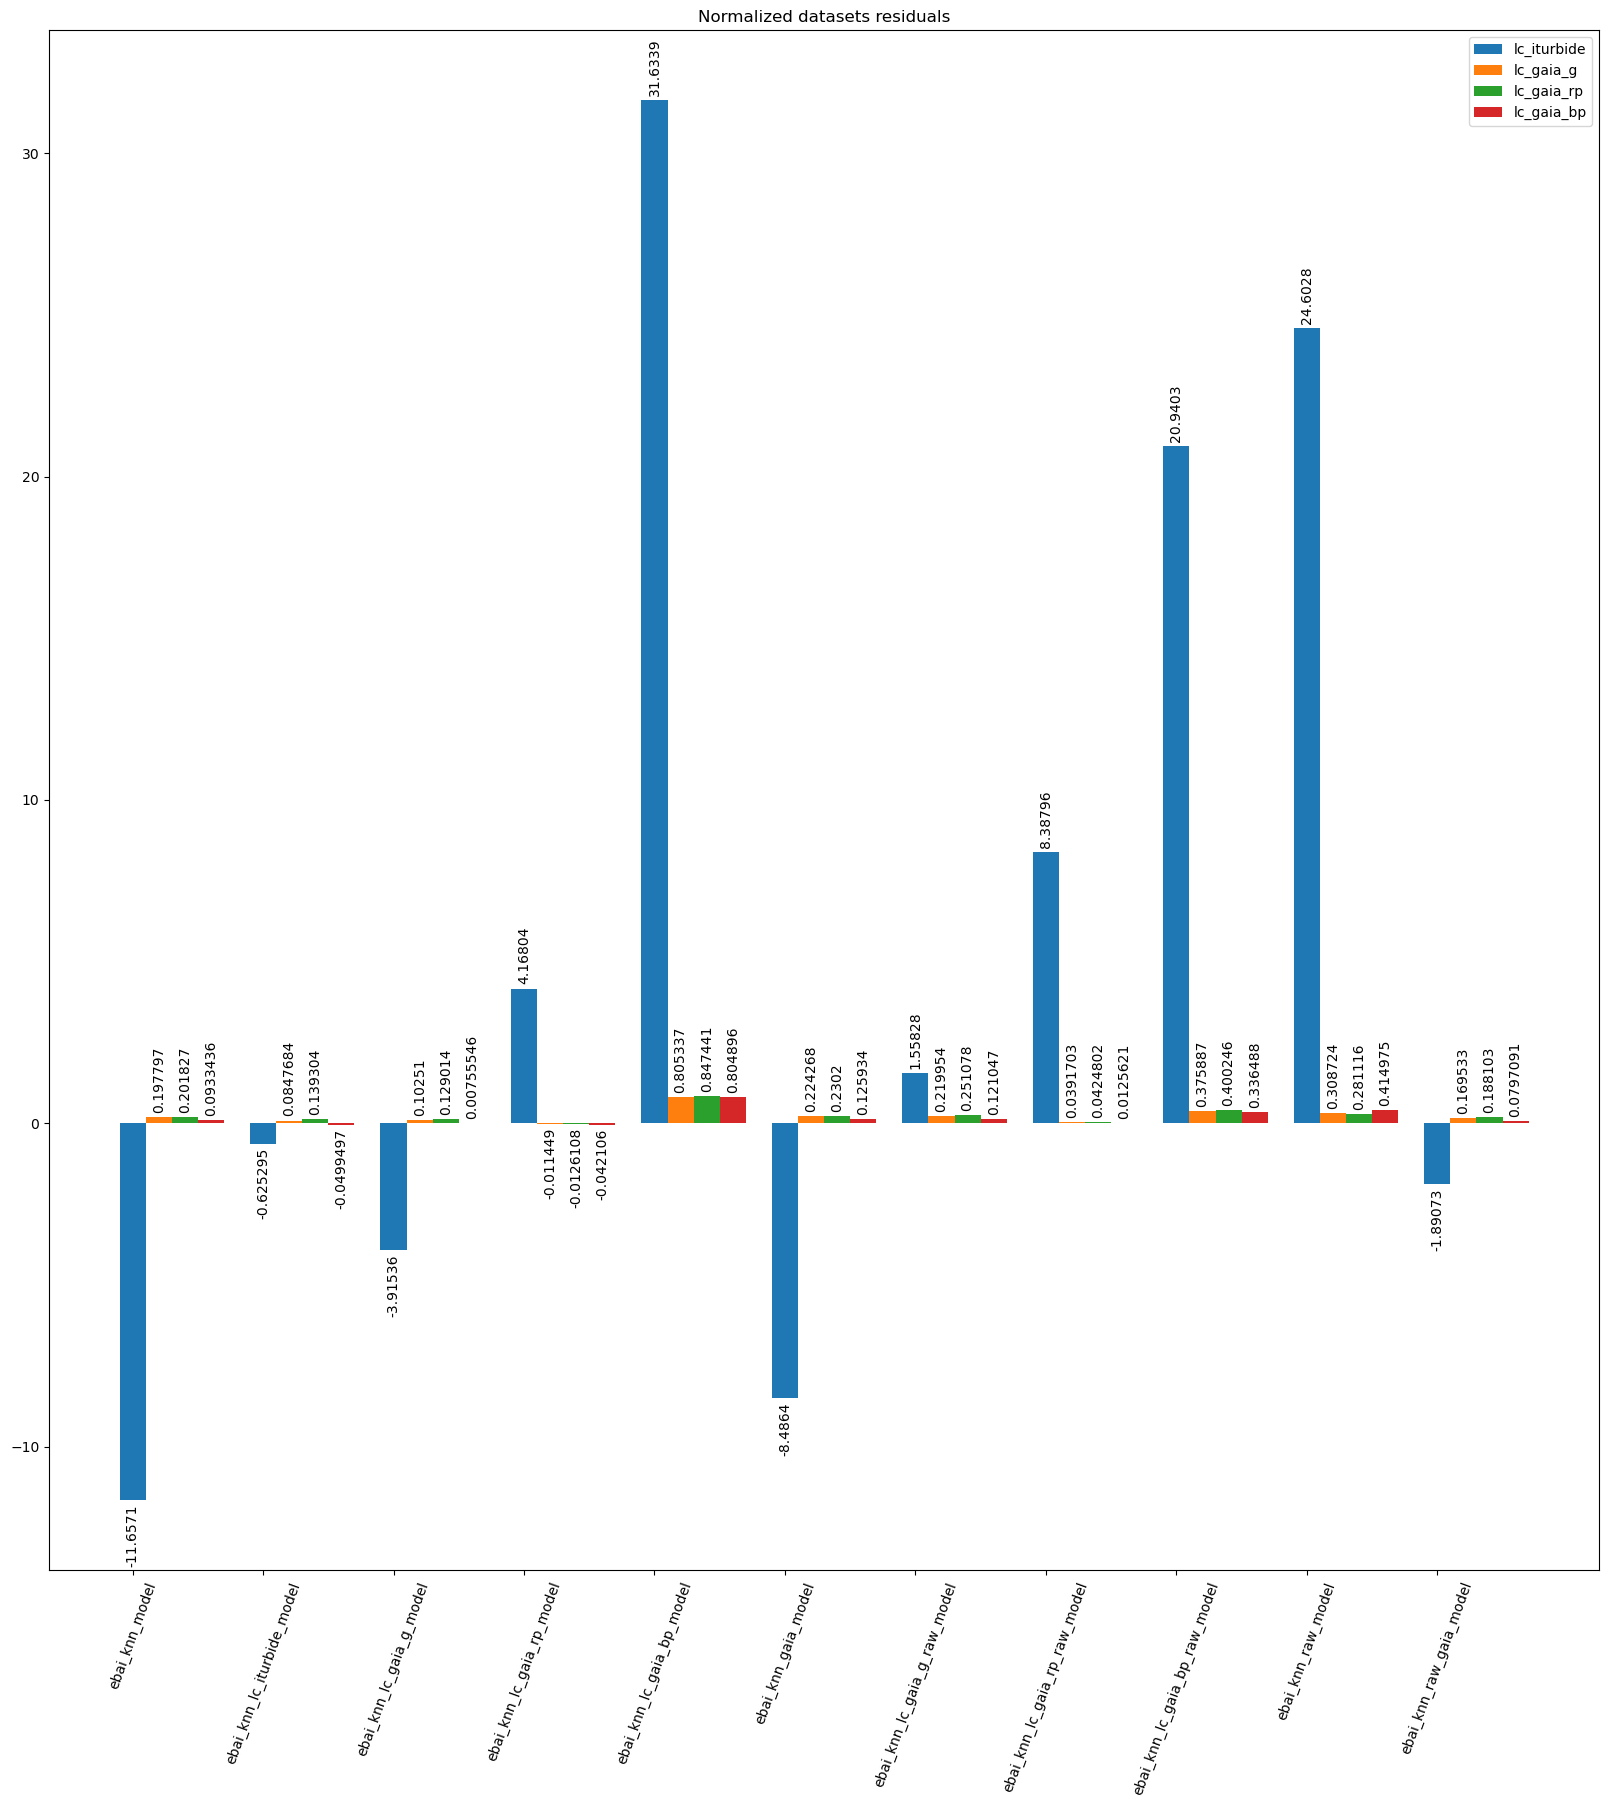

In [30]:
modelsUsed = [m for m in b.models if 'ebai_knn' in m]
barWidth = 0.2
multiplier = 0

_, ax = plt.subplots(figsize=(20, 20))

for d in normalizedDatasets:
	if d == 'mesh01':
		continue

	modelResiduals = {}
	for m in modelsUsed:
		modelResiduals[m] = np.sum(b.calculate_residuals(model=m, dataset=d))
	residualValues = list(map(lambda r: r.value, modelResiduals.values()))
	offset = barWidth * multiplier
	xpos = np.arange(len(modelsUsed)) + offset
	rects = ax.bar(xpos, residualValues, barWidth, label=d)
	ax.bar_label(rects, padding=3, rotation=90)
	multiplier += 1

ax.set_xticks(np.arange(len(modelsUsed)), modelsUsed, rotation=70)
ax.set_title("Normalized datasets residuals")

plt.legend()
plt.show()

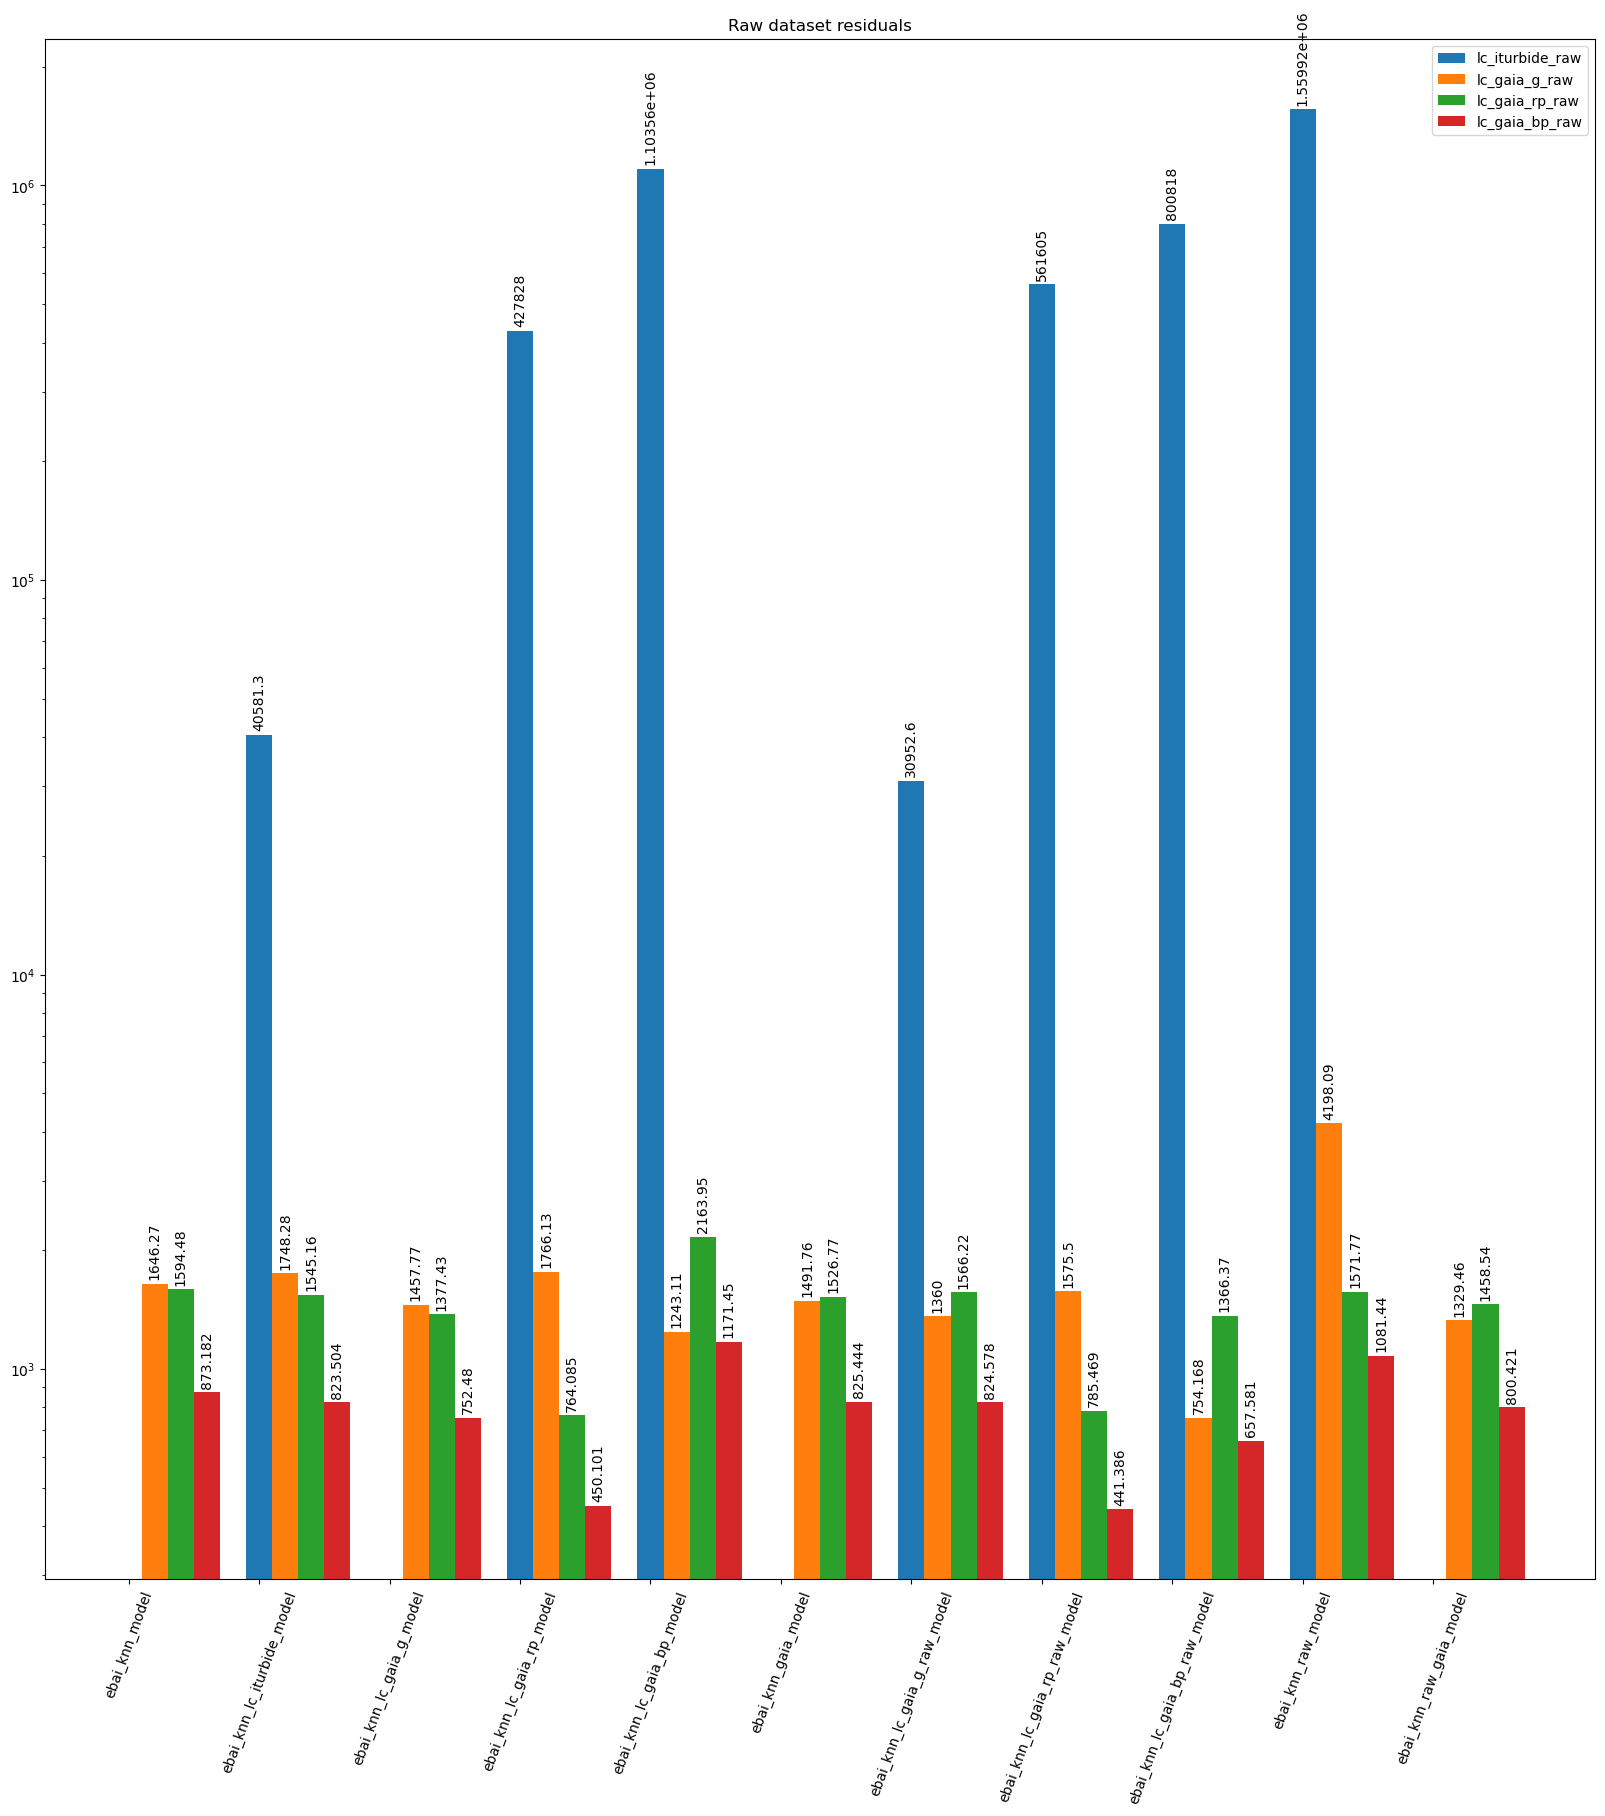

In [31]:
modelsUsed = [m for m in b.models if 'ebai_knn' in m]
barWidth = 0.2
multiplier = 0

_, ax = plt.subplots(figsize=(20, 20))

for d in allRawDatasets:
	if d == 'mesh01':
		continue

	modelResiduals = {}
	for m in modelsUsed:
		modelResiduals[m] = np.sum(b.calculate_residuals(model=m, dataset=d))
	residualValues = list(map(lambda r: r.value, modelResiduals.values()))
	offset = barWidth * multiplier
	xpos = np.arange(len(modelsUsed)) + offset
	rects = ax.bar(xpos, residualValues, barWidth, label=d)
	ax.bar_label(rects, padding=3, rotation=90)
	multiplier += 1

ax.set_xticks(np.arange(len(modelsUsed)), modelsUsed, rotation=70)
ax.set_yscale('log')
ax.set_title("Raw dataset residuals")

plt.legend()
plt.show()

Text(0.5, 1.0, '$\\chi^2$')

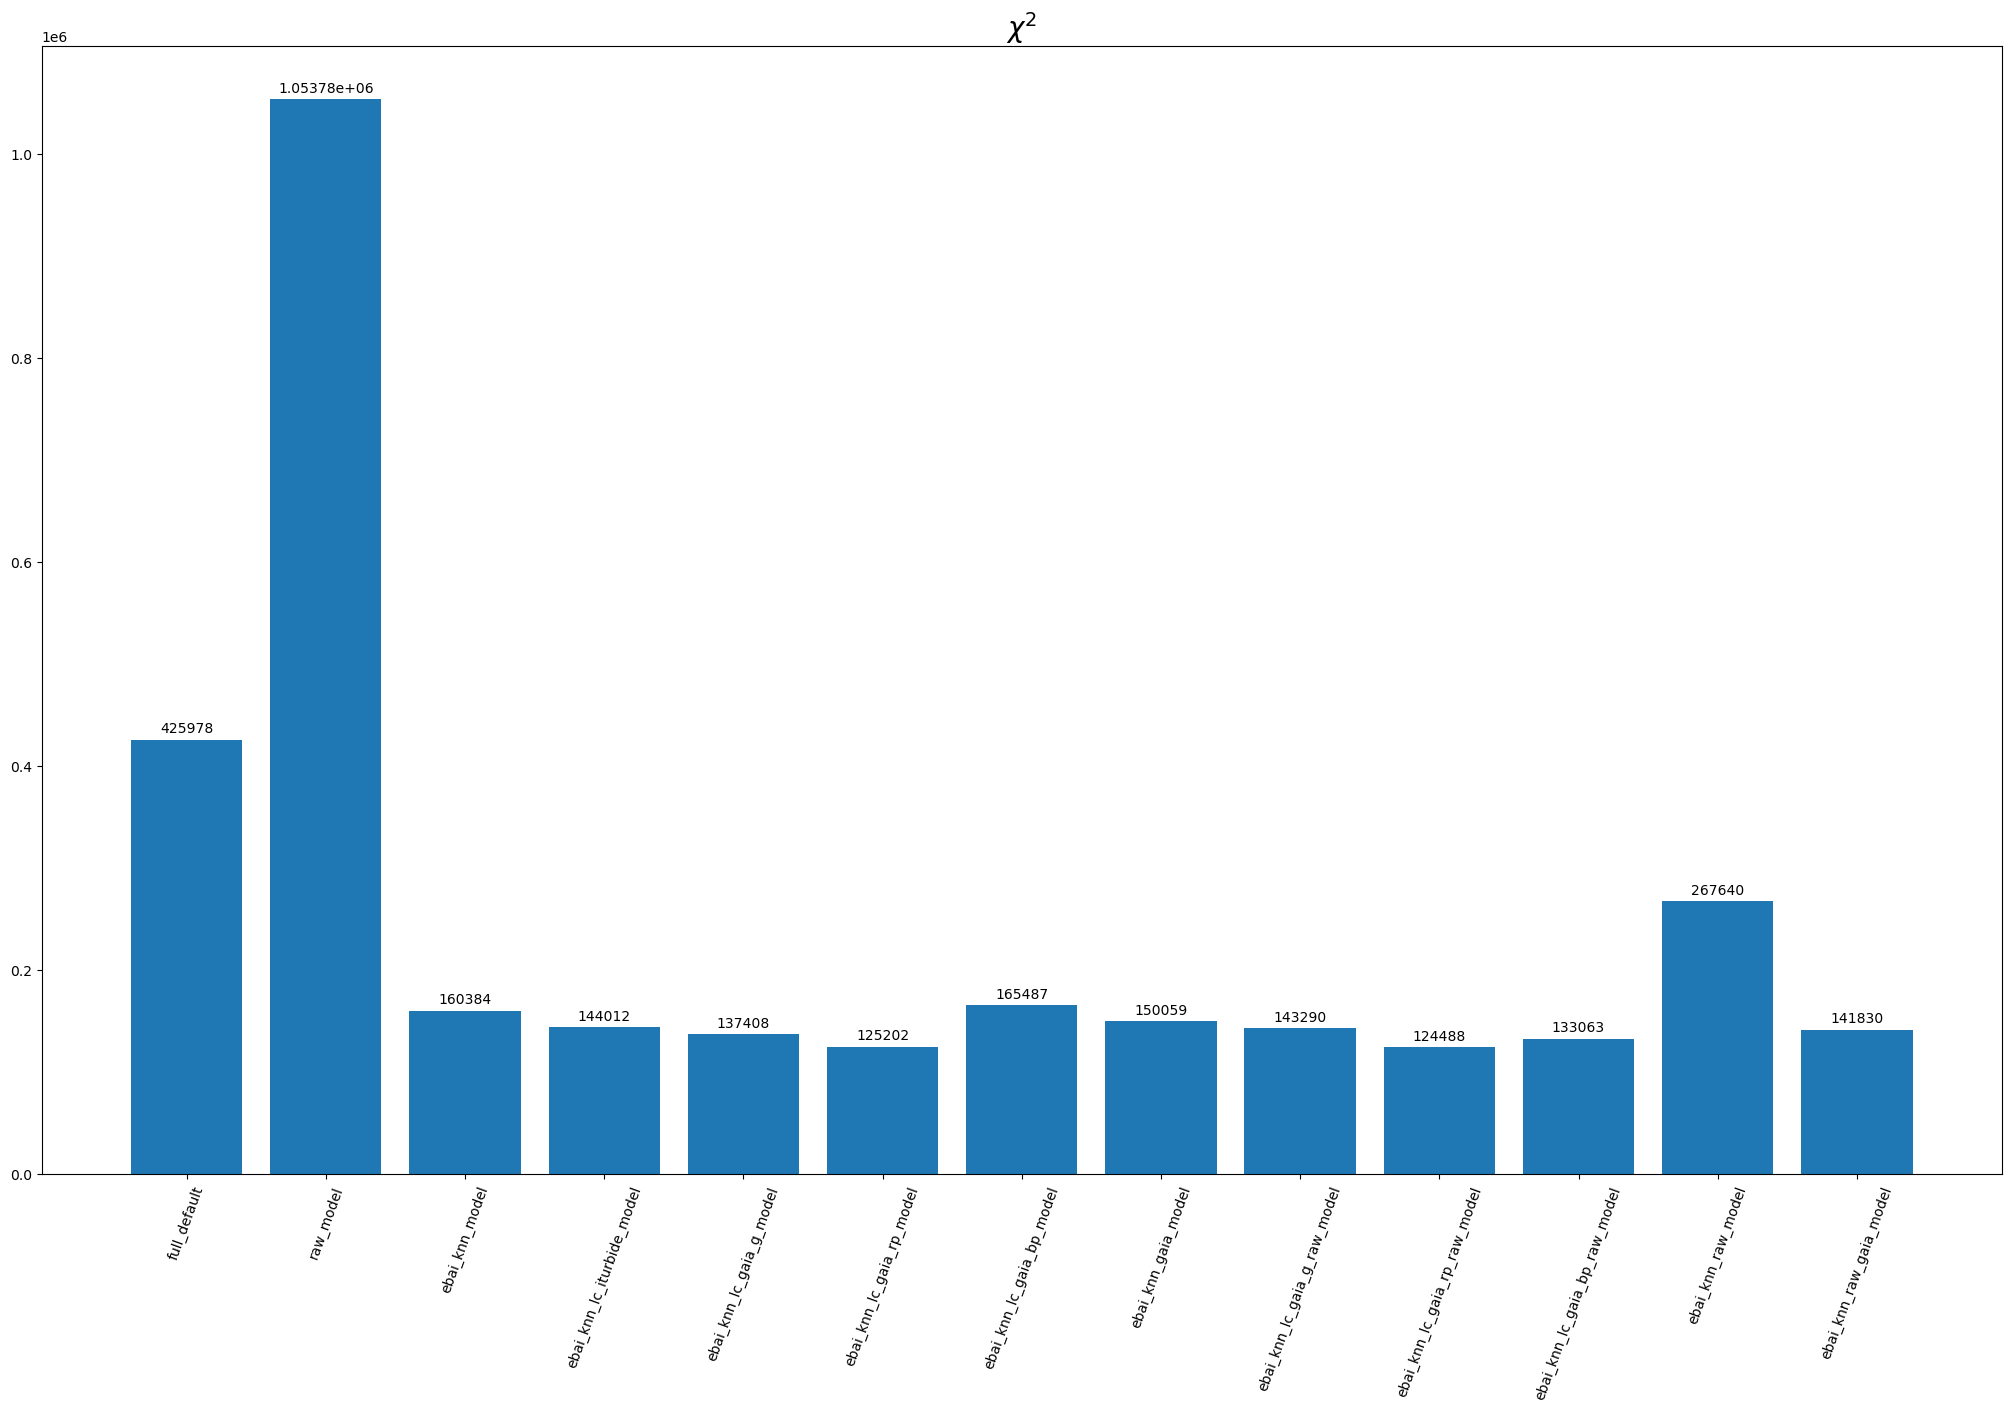

In [32]:
_, ax = plt.subplots(layout='constrained', figsize=(20, 14))
rects = ax.bar(np.arange(len(b.models)), list(map(lambda m: b.calculate_chi2(model=m, dataset=allRawDatasets + normalizedDatasets), b.models)))
ax.bar_label(rects, padding=3)
ax.set_xticks(np.arange(len(b.models)), b.models, rotation=70)
ax.set_title(r"$\chi^2$", size=20)

In [127]:
print(b['l3_mode@lc_iturbide'])
print(b['l3@lc_iturbide'])

Parameter: l3_mode@lc_iturbide@dataset
                       Qualifier: l3_mode
                     Description: Whether third light is given in units of flux or as a fraction of total light
                           Value: flux
                         Choices: flux, fraction
                  Constrained by: 
                      Constrains: None
                      Related to: None

Parameter: l3@lc_iturbide@dataset
                       Qualifier: l3
                     Description: Third light in flux units
                           Value: 0.0 W / m2
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: l3_mode:flux



## Save estimator bundle

In [33]:
# b.save("./bundle-saves/ebai-estimates")
b.save("./bundle-saves/ebai-solver-runs-no-estimates")

# TODO: pick one of the red Gaia models to start optimizing

'./bundle-saves/ebai-solver-runs-no-estimates'